In [1]:
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from generateLayout import *

In [3]:
num_columns = 4
grid_size = 30
min_room_size = 3
roomspace = grid_size - (num_columns + 1)
num_rooms = 9


#divisions = get_divisions(roomspace, num_columns)
#horizontal_split = list(random.choice(divisions))
#vertical_splits = [list(random.choice(divisions)) for i in horizontal_split]
#random.shuffle(horizontal_split)
#for split in vertical_splits:
#    random.shuffle(split)
#horizontal_data = []
#x_accum = 1
#for part in horizontal_split:
#    horizontal_data.append((x_accum,part))
#    x_accum += part+1

#vertical_data = []
#for split in vertical_splits:
#    y_accum = 1
#    data = []
#    for part in split:
#        data.append((y_accum,part))
#        y_accum += part+1
#    vertical_data.append(data)
divisions = get_divisions(roomspace, num_columns,min_room_size)
walkable_points, chosen_rooms = get_choosen_rooms(divisions,min_room_size,num_rooms)


In [4]:
print(create_string(walkable_points,grid_size))

##############################
###############   ############
###############   ############
###############   ############
###############   ############
###############   ############
###############   ############
###############   ############
##############################
###############   ############
###############   ############
###############   #          #
#         #####   #          #
#         #########          #
#         #####   #          #
###############   ############
###############   #          #
###########   #   #          #
###########   #   #          #
###########   #####          #
###########   #   #          #
###############   #          #
###########   #   #          #
###########   #   #          #
###########   #   #          #
###############   #          #
###############   #          #
###############   #          #
###############   #          #
##############################



In [5]:
distances = {}
for i,r1 in enumerate(chosen_rooms):
    for j,r2 in enumerate(chosen_rooms):
        if i<j:
            distances[(i,j)]=get_distance(r1,r2)


In [6]:
sorted_pairs=list(sorted(map(lambda x:(x[0],x[1]),distances.items()),key=lambda x:x[1]))

In [7]:
G = get_grid_graph(grid_size,walkable_points,chosen_rooms)

In [8]:
paths = get_paths(G,sorted_pairs,chosen_rooms,grid_size)


In [10]:
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points  = get_room_points(chosen_rooms)

room_G = get_rooms_graph(chosen_rooms,paths_lst,rooms_points)


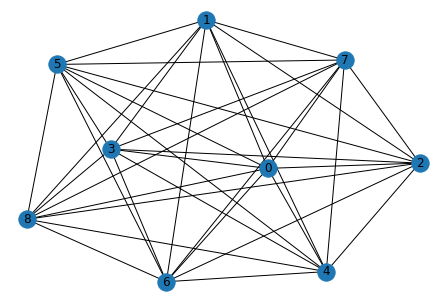

In [11]:
nx.draw(room_G, with_labels=True)
edgs=room_G.edges(data=True)

In [12]:
for e in edgs:
    print(e)

(0, 8, {'corridor_key': 0, 'crossed_corridors': [], 'crossed_rooms': []})
(0, 4, {'corridor_key': 13, 'crossed_corridors': [28, 29], 'crossed_rooms': []})
(0, 6, {'corridor_key': 23, 'crossed_corridors': [11, 14, 16, 20, 25, 31, 33], 'crossed_rooms': [8]})
(0, 2, {'corridor_key': 24, 'crossed_corridors': [29, 34, 35], 'crossed_rooms': []})
(0, 1, {'corridor_key': 28, 'crossed_corridors': [1, 7, 8, 13, 21, 22, 29, 30], 'crossed_rooms': [4]})
(0, 3, {'corridor_key': 31, 'crossed_corridors': [16, 19, 20, 23, 33], 'crossed_rooms': [8]})
(0, 7, {'corridor_key': 34, 'crossed_corridors': [24, 27, 29, 32, 35], 'crossed_rooms': [2]})
(0, 5, {'corridor_key': 35, 'crossed_corridors': [6, 24, 26, 27, 29, 32, 34], 'crossed_rooms': [2]})
(1, 4, {'corridor_key': 1, 'crossed_corridors': [21, 28], 'crossed_rooms': []})
(1, 6, {'corridor_key': 2, 'crossed_corridors': [14, 17], 'crossed_rooms': []})
(1, 7, {'corridor_key': 3, 'crossed_corridors': [18, 21], 'crossed_rooms': []})
(1, 8, {'corridor_key': 14

In [78]:

available_indices = set(range(num_rooms))



In [85]:
splits_it = iterate_G(available_indices,[3,3,3],0,room_G)
found = False
for i,split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels)==3:
            found = True
            print(i,'::::',skels)
            break
    #if i>100:
    if found==True:
        break

0 :::: [{'edges': {0, 22}, 'intersections': {0, 32, 34, 35, 13, 15, 21, 22, 23, 26, 28, 29}}, {'edges': {25, 14}, 'intersections': {34, 12, 14, 17, 21, 24, 25, 27, 30}}, {'edges': {4, 6}, 'intersections': {32, 33, 10, 11, 18, 20}}]


In [87]:
skels

[{'edges': {0, 22},
  'intersections': {0, 13, 15, 21, 22, 23, 26, 28, 29, 32, 34, 35}},
 {'edges': {14, 25}, 'intersections': {12, 14, 17, 21, 24, 25, 27, 30, 34}},
 {'edges': {4, 6}, 'intersections': {10, 11, 18, 20, 32, 33}}]

In [88]:
vertices_edges_dict = nx.get_edge_attributes(room_G,'corridor_key')
vertices_edges_dict_inv = {v: k for k, v in vertices_edges_dict.items()}

In [89]:
print(vertices_edges_dict)

{(0, 5): 0, (0, 7): 1, (0, 8): 2, (0, 2): 12, (0, 6): 16, (0, 4): 20, (0, 1): 22, (0, 3): 23, (1, 6): 3, (1, 5): 13, (1, 2): 27, (1, 7): 28, (1, 8): 29, (1, 3): 31, (1, 4): 33, (2, 8): 14, (2, 6): 17, (2, 5): 21, (2, 7): 24, (2, 4): 30, (2, 3): 34, (3, 4): 4, (3, 5): 5, (3, 7): 11, (3, 8): 18, (3, 6): 35, (4, 7): 6, (4, 8): 7, (4, 5): 10, (4, 6): 32, (5, 7): 8, (5, 6): 15, (5, 8): 19, (6, 8): 25, (6, 7): 26, (7, 8): 9}


In [119]:
%autoreload 2
from generateLayout import *

In [100]:
get_points_from_group(2, skels, vertices_edges_dict_inv,room_G,paths_lst)

{(14, 6),
 (14, 7),
 (14, 8),
 (14, 9),
 (15, 6),
 (15, 7),
 (15, 8),
 (15, 9),
 (16, 6),
 (16, 7),
 (16, 8),
 (16, 9),
 (17, 6),
 (17, 7),
 (17, 8),
 (17, 9),
 (18, 6),
 (18, 7),
 (18, 8),
 (18, 9),
 (19, 9),
 (20, 6),
 (20, 7),
 (20, 8),
 (20, 9),
 (21, 6),
 (21, 7),
 (21, 8),
 (21, 9),
 (21, 11),
 (21, 12),
 (21, 13),
 (21, 14),
 (22, 6),
 (22, 7),
 (22, 8),
 (22, 9),
 (22, 11),
 (22, 12),
 (22, 13),
 (22, 14),
 (23, 6),
 (23, 7),
 (23, 8),
 (23, 9),
 (23, 11),
 (23, 12),
 (23, 13),
 (23, 14),
 (24, 6),
 (24, 7),
 (24, 8),
 (24, 9),
 (24, 11),
 (24, 12),
 (24, 13),
 (24, 14),
 (25, 6),
 (25, 7),
 (25, 8),
 (25, 9),
 (25, 10),
 (25, 11),
 (25, 12),
 (25, 13),
 (25, 14),
 (26, 6),
 (26, 7),
 (26, 8),
 (26, 9),
 (26, 11),
 (26, 12),
 (26, 13),
 (26, 14),
 (27, 6),
 (27, 7),
 (27, 8),
 (27, 9),
 (27, 11),
 (27, 12),
 (27, 13),
 (27, 14)}

In [103]:

get_points_from_room(1,room_G)

[(0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (3, 25),
 (3, 26),
 (3, 27),
 (4, 16),
 (4, 17),
 (4, 18),
 (4, 19),
 (4, 20),
 (4, 21),
 (4, 22),
 (4, 23),
 (4, 24),
 (4, 25),
 (4, 26),
 (4, 27)]

In [692]:
# skels is a list of skeletons for each group such as the one in the cell above
# [{'edges': {0, 12}, 'intersections': {15, 21, 24, 25, 28, 29}},
# {'edges': {5, 34}, 'intersections': {31, 35}},
# {'edges': {9, 10}, 'intersections': {14}}]
# groups is a tuple of indices (i,j) of the groups which should be connected..it uses the skels list indices
# [0,1]
# setA = get all vertices from group i (use get_vertices_from_edge_ids)
# setB = get all vertices from group j (use get_vertices_from_edge_ids)
# create all possible pairs (crossing edges) where the first element is from setA and the second from setB
# iterate over the crossing edges (refered here as e): (itertools)
# now when we speak about corridors we mean corridors which are present in the skeletons in the skel list
# these corridors are stored in the 'edges' key of a given skeleton
# if the crossing_edge e intersects some room or corridor from some other group than i or j then skip this edge (other groups are present in skels list)
# intA = get intersection between the crossing edge e and anything (either room or chosen corridor) in group i
# intB = same thing but for group j
# if both intA and intB are not empty then skip this crossing edge
# else return this edge

In [110]:
groups_to_connect = (0,1)

crossing_edges = get_crossing_edges(skels, groups_to_connect,vertices_edges_dict_inv,vertices_edges_dict)
print(crossing_edges)

[(0, 8), (0, 2), (0, 6), (1, 8), (1, 2), (1, 6), (5, 8), (5, 6), (2, 5)]


In [120]:
get_edges_from_skels(crossing_edges, groups_to_connect, skels,vertices_edges_dict_inv,room_G,paths_lst,vertices_edges_dict)

2

In [122]:
ix = 2
print(paths_lst[ix][0])
walkable_points1 = set(list(walkable_points) + list(map(toL,paths_lst[ix][1])))
print(create_string(walkable_points1,grid_size))

(0, 8)
##############################
#     ######    #            #
#     ######    #            #
#     ######    #            #
#     ######    #            #
#     ###########            #
#     ########################
##############################
##############################
##############################
#######    #    ##############
#######    #    ##############
#     #    #    ##############
#          #    ##############
#     ######    ##############
#     #    #    ##############
#     #    #    ##############
#     #    #    ##############
#     #    #    ##############
#     #    #    ##############
#     ######    ##############
#     #    ###################
#     #    #    ##############
#     #    #    ##############
#######    #    ##############
#######    #    ##############
#######    #    ##############
#######    #    ##############
#######    #    ##############
##############################



In [696]:
paths_lst[4]

((2, 3),
 [(13, 9), (13, 8), (13, 7), (13, 6), (13, 5), (13, 4), (13, 3), (12, 3)])